In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("operations.csv")
data.head()

,transaction_date,label,amount,balance_bef_trn,categ,type,expense_slice,debcr,year,month,day,day_week,day_week_num,weekend,quart_month
0,2023-03-31,DONATION XX XX XX XX XX XX XX,-1.44,1515.25,OTHER,DONATION,small,debit,2023,3,31,Friday,5,False,4
1,2023-04-03,PAYMENT XX XX MTA XX,-24.00,1513.81,TRANSPORT,PAYMENT,small,debit,2023,4,3,Monday,1,False,1
2,2023-04-03,PAYMENT XX XX MTA XX,-73.00,1489.81,TRANSPORT,PAYMENT,small,debit,2023,4,3,Monday,1,False,1
3,2023-04-03,PAYMENT XX XX XX XX,-14.39,1416.81,OTHER,PAYMENT,small,debit,2023,4,3,Monday,1,False,1
4,2023-04-03,TRANSFER XX XX XX XX XX XX,4.80,1402.42,OTHER,TRANSFER,(not an expense),credit,2023,4,3,Monday,1,False,1


In [3]:
# "GROCERIES" Sub-samples
groceries = data[data.categ == "GROCERIES"]

# Transactions are sorted by date
groceries = groceries.sort_values("transaction_date")

# Expenses are coverted to a positive number
groceries["amount"] = -groceries["amount"]

# Covert "transaction_date" to date from str
groceries["transaction_date"] = pd.to_datetime(groceries["transaction_date"],format="%Y-%m-%d")

groceries.head()

,transaction_date,label,amount,balance_bef_trn,categ,type,expense_slice,debcr,year,month,day,day_week,day_week_num,weekend,quart_month
8,2023-04-05,PAYMENT XX XX TRADER JANE’S XX,6.80,2061.00,GROCERIES,PAYMENT,small,debit,2023,4,5,Wednesday,3,False,1
13,2023-04-10,PAYMENT XX XX TRADER JANE’S XX,42.42,3030.46,GROCERIES,PAYMENT,small,debit,2023,4,10,Monday,1,False,2
43,2023-04-25,PAYMENT XX XX TRADER JANE’S XX,32.67,3647.67,GROCERIES,PAYMENT,small,debit,2023,4,25,Tuesday,2,False,4
45,2023-04-26,PAYMENT XX XX WEST END MARKET XX XX,1.90,3605.00,GROCERIES,PAYMENT,small,debit,2023,4,26,Wednesday,3,False,4
47,2023-04-28,PAYMENT XX XX TRADER JANE’S XX,9.11,3601.70,GROCERIES,PAYMENT,small,debit,2023,4,28,Friday,5,False,4


In [4]:
# Calculating wait variable
r = []
last_date = dt.datetime.now()

for i,row in groceries.iterrows():
    #print(last_date)
    #print(i)
    days = (row["transaction_date"]-last_date).days
    #print(days)
    if days == 0:
        r.append(r[-1])
    else:
        r.append(days)
    #print(r)
    last_date = row["transaction_date"]
groceries["wait"] = r
groceries = groceries.iloc[1:,]

In [5]:
# transactions made on the same date are grouped together
# (groceries bought the same day but in 2 different stores)
a = groceries.groupby("transaction_date")["amount"].sum()
b = groceries.groupby("transaction_date")["wait"].first()

groceries = pd.DataFrame([a for a in zip(a,b)])
groceries.columns = ["amount","wait"]

In [6]:
Y = groceries["amount"]
X = groceries[["wait"]]
X = X.copy()
X["intercept"] = 1.
result = sm.OLS(Y,X).fit()
a,b = result.params['wait'], result.params['intercept']

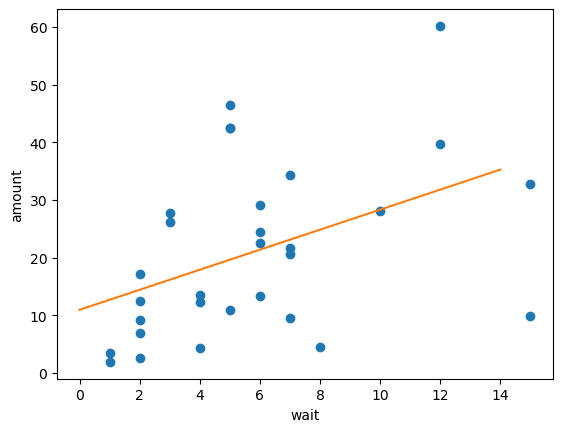

In [9]:
plt.plot(groceries.wait,groceries.amount,"o")
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)])
plt.xlabel("wait")
plt.ylabel("amount")
plt.show()